# Quantum Information and Computing
## Tensor networks as neural network layers for supervised learning

### Index

1. Introduction
2. Using tensor networks for classification tasks
    - Toy model
    - MNIST handwritten digits
    - Fruit and vegetable recognition
3. Comparison with standard neural networks
    - Fully-connected networks
    - Convolutional networks

## Introduction

# ##Placeholder for intro block##

## Using tensor networks for classification tasks

In order to simplify computational tasks, a combination of the modules ```TensorFlow``` and ```TensorNetwork``` has been used.

- [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf), [source](https://github.com/tensorflow/tensorflow)
- [TensorNetwork documentation](https://tensornetwork.readthedocs.io/en/latest/), [source](https://github.com/google/TensorNetwork)

### Basic toy model

#### Data generation

In [1]:
from final import *
%load_ext autoreload
%autoreload 2
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


2022-03-06 19:58:05.702840: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
unit_sq = np.mgrid[0:1:.001, 0:1:.001]

#Initialize multivar gaussian distributions
rv_tL = mv_norm([0., 1.], [[0.1, 0], [0., 0.15]]) #top-Left gaussian
rv_bR = mv_norm([1., 0.], [[0.175, 0], [0., 0.09]]) #bottom-Right gaussian

#Generate the multivariate density functions
pos = np.dstack(unit_sq)
dist1 = rv_tL.pdf(pos)
dist2 = rv_bR.pdf(pos)

#Compute the optimal theoretical boundary
x_vals, y_est = optimal_boundary(dist1, dist2, unit_sq, tolerance=1e-4)

#Generate data samples and labels to use in the classification task.
x1, labels1, x2, labels2 = gen_samples(1000, rv_tL, rv_bR)
x, labels = np.vstack([x1,x2]), np.vstack([labels1,labels2]).flatten()


#Generate random shuffler for the data
shuffler = np.random.permutation(len(x))
x, labels = x[shuffler], labels[shuffler]
#shuffle and split data into training and test sets.
x_train, x_test, labels_train, labels_test = train_test_split(x, labels, test_size=0.2, random_state=420)

For this toy model, the objective function is chosen as the binary negative logarithm loss. Because of this, the output ought to have two components, each indicating the likelihood of predicting either label. These are obtained at the free index of the tensor network, upon application of a softmax activation on the resulting tensor components.

The model will aim to approximate the separating curve as illustrated in the plots below. This is the theoretical optimal separating plane, defined as the set of locations where the two distributions are equal $-$ where a classifier will predict either class with equal probability.

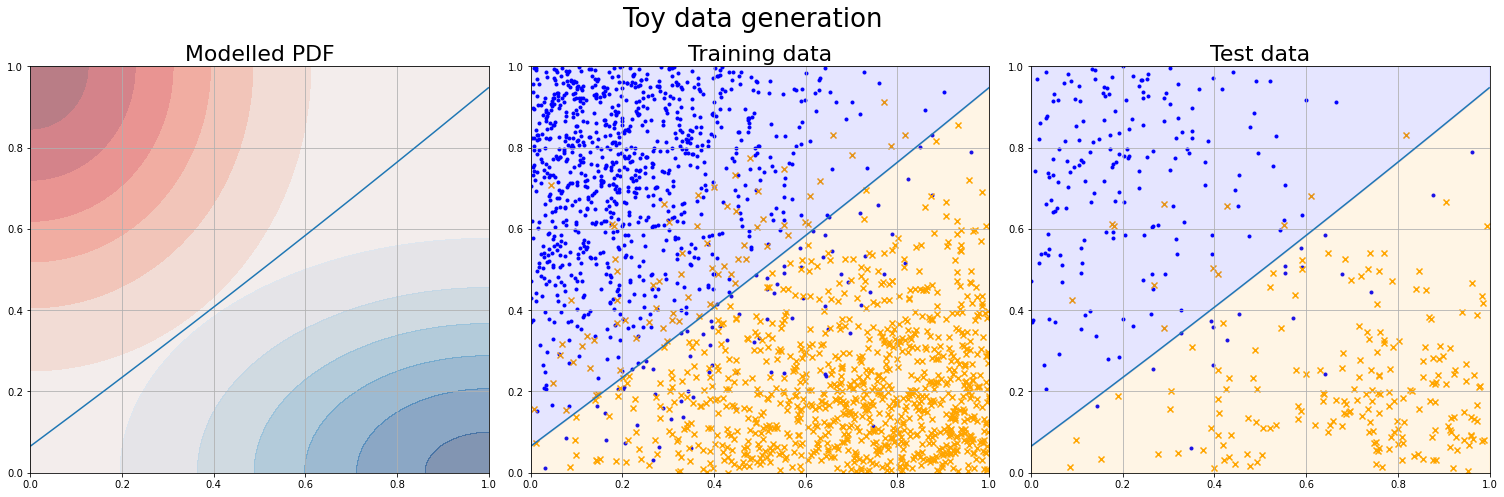

In [3]:
toy_plot = toy_model_plot(unit_sq, dist1, dist2, x_vals, y_est, x1, x2, x_test, labels_test)

#### Feature mapping

The matrix product state will have as many nodes as feature inputs. Having two dimensional data $(x_1, x_2)$, the feature map will have rank 2:

$$
\Phi(x_1, x_2) = \phi^{s_1}(x_1) \otimes \phi^{s_2}(x_2)
$$

Where $\phi(\cdot)$ is a feature map $\phi : \mathbb{R} \rightarrow \mathbb{R^d}$ where $d$ is the number of components of each index $s_{i}$ of the input $\Phi$. The impact of this value will be studied further.

The mapping is chosen as follows:
$$
\phi(x)_{s_i} = \sqrt{\binom{d - 1}{s_i - 1}} \cos^{d - s_i}\left(\frac{\pi}{2}x \right) \sin^{s_i - 1}\left(\frac{\pi}{2}x\right)
$$

It can be promptly shown that this mapping will be normalized to unity for any value of $d$.

In [4]:
d=3
#Feature mapping dataset
x_ftrain, y_htrain, x_ftest, y_htest = fmap(d, x_train, x_test, labels_train, labels_test)

2022-03-06 19:58:08.273269: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-06 19:58:08.294908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 19:58:08.295014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-03-06 19:58:08.295037: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-06 19:58:08.298670: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-06 19:58:08.298744: I tensorflow/stream_executor/pl

The tensor network is defined as a ```Keras``` model of a single layer. This allows for easy implementation of different algorithms of gradient descent and the respective back-propagation.

The layer is defined as a subclass of ```tensorflow.keras.layers.Layer```, inheriting its methods and attributes. The number of nodes in the matrix product state (MPS) equals the dimensionality of the input: an $N$-dimensional input will yield a tensor of rank $N$. With two-dimensional toy data, we use two MPS tensors. The bond dimension can be tuned as a hyper-parameter of the model. A larger bond dimension will, in principle, augment the classifier's predictive power.

2022-03-06 19:58:10.531889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-06 19:58:10.550828: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


Total training time: 6.1053 seconds over 100 epochs.


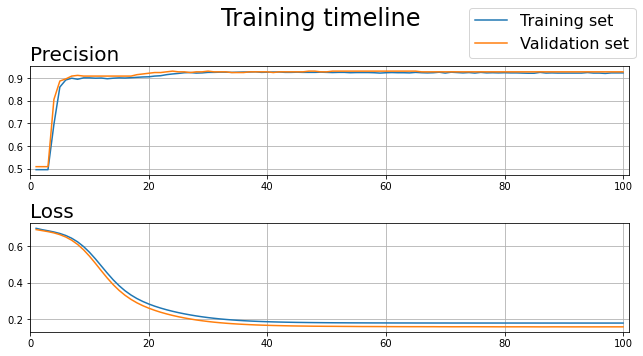

In [5]:
#model training

bond_dim = 5
tnetwork = build_model(d, bond_dim, 'SGD', batch_size=None)

t_i = time.time()
history = tnetwork.fit(x_ftrain, y_htrain, batch_size=16, validation_split=0.2, epochs=100, verbose=0, shuffle=True)
t_f = time.time()
delta_t = t_f - t_i
#plotting history
history_plot = plot_loss_acc(history.history, figsize = (9, 5), tight_layout='pad')
print(f'Total training time: {delta_t:.4f} seconds over {len(history.epoch)} epochs.')




Model achieved 91.750% precision on the test set.
Model achieved 92.250% precision on the test set.
Model achieved 92.750% precision on the test set.
Model achieved 91.750% precision on the test set.
Model achieved 91.750% precision on the test set.
Model achieved 92.750% precision on the test set.
Model achieved 86.750% precision on the test set.
Model achieved 92.000% precision on the test set.
Model achieved 92.000% precision on the test set.


/tmp/ipykernel_34362/1006743685.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_contours.show()


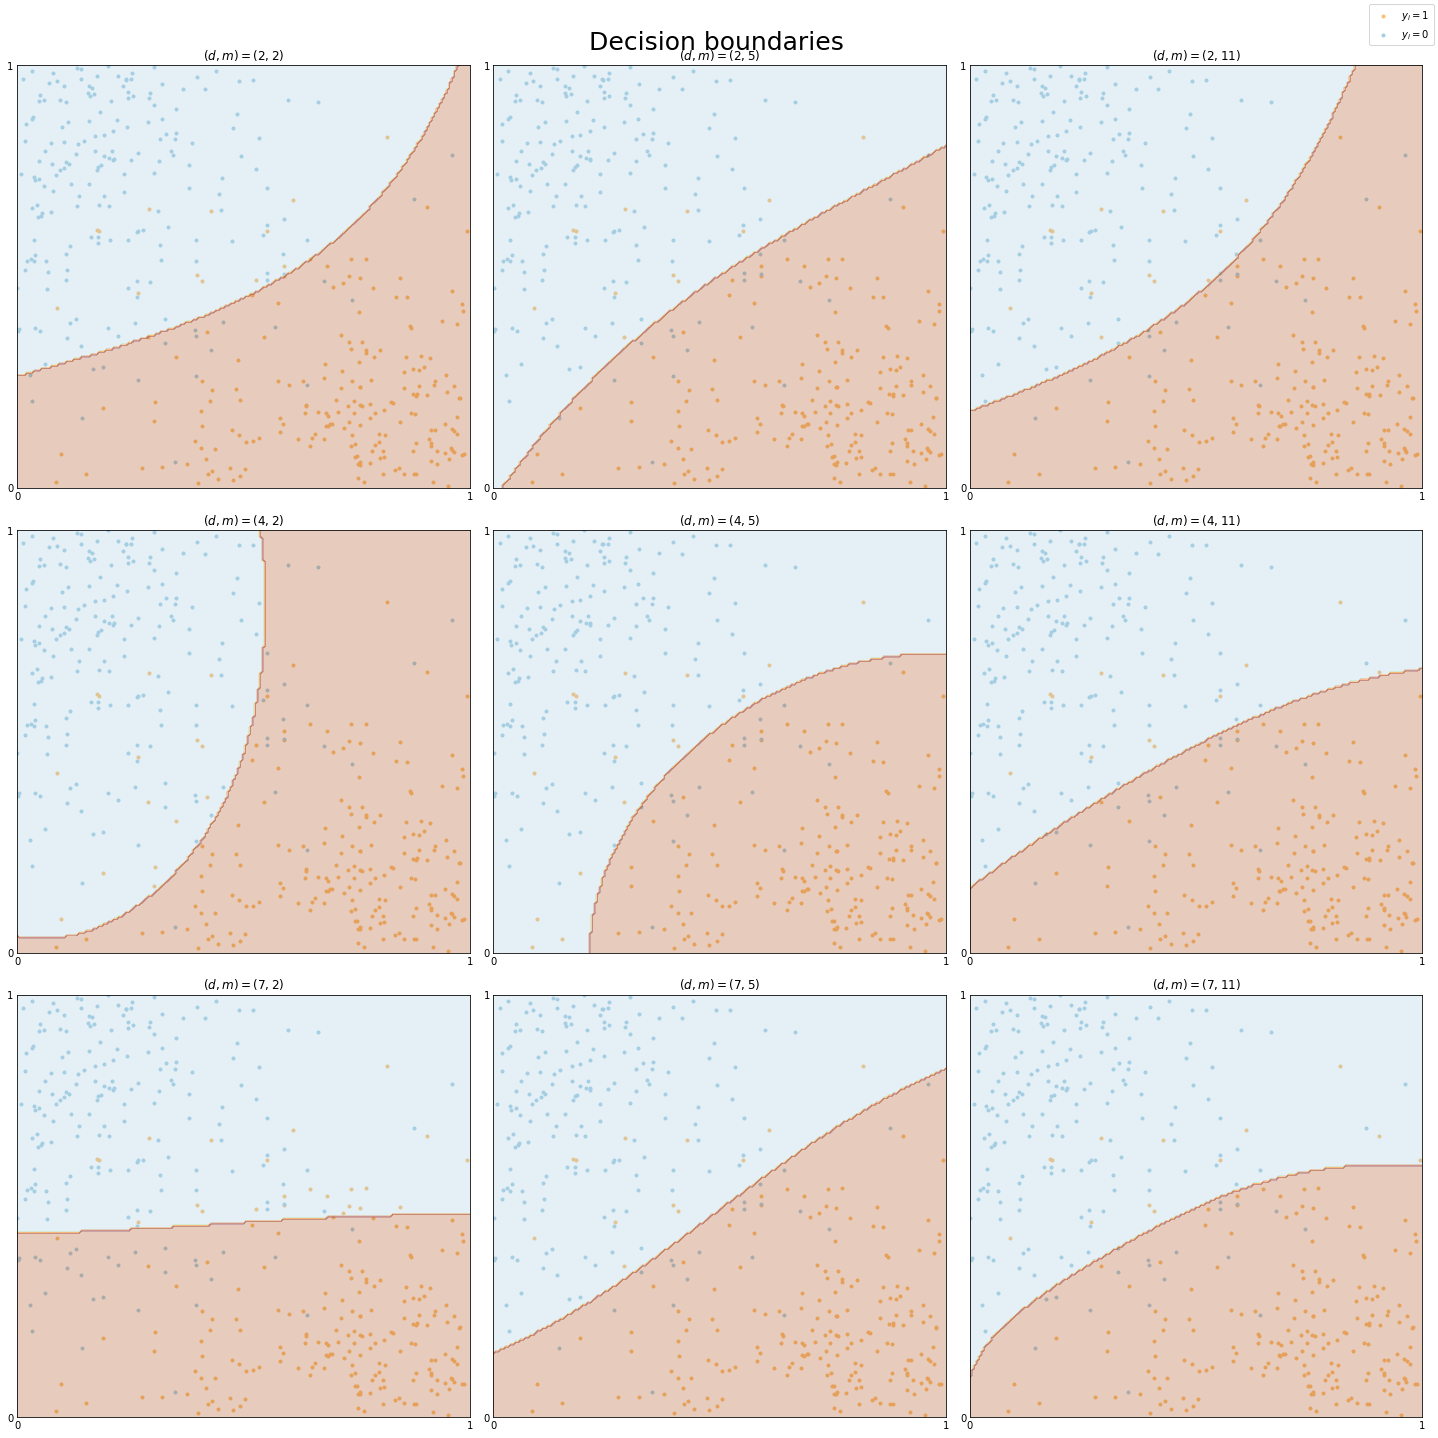

In [6]:
m_list = [2, 5, 11]
d_list = [2, 4, 7]

fig_contours, axs = decision_contours(d_list, m_list,
                            x_train, x_test, labels_train, labels_test,
                            tight_layout = 'pad', figsize=(20,20))

fig_contours.show()                            

### MNIST

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data('mnist.npz')
x_train, x_test = x_train.reshape((60000, 28, 28, 1)), x_test.reshape((10000, 28, 28, 1))

x_train, x_test = tf.convert_to_tensor(x_train), tf.convert_to_tensor(x_test)
y_train, y_test = tf.one_hot(y_train, 10), tf.one_hot(y_test, 10)
in_shape = x_train[0].shape

In [8]:
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D
Flatten = tf.keras.layers.Flatten


tn_MNIST = tf.keras.Sequential(
    [
     tf.keras.Input(shape=in_shape, batch_size=4096),
     Conv2D(28, (4,4), strides = (1,1), name='conv1'),
     MaxPooling2D((2,2), name='maxpool1'),
     Flatten(),
     MNIST_TN(bond_dim = 11),
     Dense(10, activation='softmax', name='out_layer')])
tn_MNIST.summary()

tn_MNIST.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['Precision'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (4096, 25, 25, 28)        476       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (4096, 12, 12, 28)        0         
_________________________________________________________________
flatten (Flatten)            (4096, 4032)              0         
_________________________________________________________________
mnist_tn (MNIST_TN)          (4096, 256)               61504     
_________________________________________________________________
out_layer (Dense)            (4096, 10)                2570      
Total params: 64,550
Trainable params: 64,550
Non-trainable params: 0
_________________________________________________________________


In [9]:
check_point = ModelCheckpoint(filepath = os.getcwd()+'/tn_MNIST.hdf5', verbose = 0, save_best_only = True)

hist_dict = tn_MNIST.fit(x_train, y_train, batch_size = 16, epochs = 10, verbose = 0, validation_split = 0.2, shuffle=True, callbacks=[check_point])

TypeError: ('Not JSON Serializable:', <tf.Variable 'a:0' shape=(16, 12, 11) dtype=float32, numpy=
array([[[-0.03671432,  0.05942908,  0.04454144, ..., -0.01343169,
          0.04602731, -0.0231769 ],
        [-0.01443814, -0.0673369 ,  0.01951546, ..., -0.07349803,
          0.00260094, -0.05565425],
        [-0.01615309, -0.0591575 , -0.08902172, ...,  0.00877018,
         -0.01860435,  0.00927398],
        ...,
        [-0.01952234, -0.04726873,  0.00164308, ...,  0.03379926,
         -0.03000916, -0.00540438],
        [ 0.00510874, -0.00662848,  0.02160953, ..., -0.02135743,
         -0.03825377, -0.0150745 ],
        [-0.03919933, -0.09500369, -0.02090335, ...,  0.01516907,
         -0.05258369,  0.00063142]],

       [[ 0.02693762, -0.01314013, -0.02817396, ...,  0.0326256 ,
          0.02178578,  0.02718937],
        [ 0.00620379, -0.00166124, -0.04131987, ..., -0.02228274,
         -0.04205252, -0.01104988],
        [ 0.01259062,  0.00379065, -0.0079461 , ...,  0.03701138,
         -0.00813632,  0.02603388],
        ...,
        [ 0.03537327, -0.03446721,  0.04184793, ...,  0.04801091,
         -0.04304152,  0.01174957],
        [-0.03134172, -0.04035397,  0.00843579, ...,  0.00611692,
         -0.07946897,  0.01855959],
        [-0.04776837, -0.01640597, -0.03554611, ..., -0.0469901 ,
         -0.04099501, -0.01647415]],

       [[ 0.01553669,  0.01140913, -0.04160156, ...,  0.06566028,
         -0.00336671, -0.05765069],
        [ 0.01357953, -0.01691724,  0.02045645, ...,  0.00310486,
         -0.02700325, -0.02210886],
        [ 0.00779664, -0.01133555, -0.00030889, ..., -0.01321111,
         -0.02177798, -0.03497457],
        ...,
        [-0.0087769 , -0.01949579, -0.00746623, ...,  0.01684182,
          0.00946559,  0.023178  ],
        [-0.019485  ,  0.04238844,  0.00235505, ...,  0.08393873,
         -0.03719432,  0.00254696],
        [ 0.03199272,  0.00884657,  0.01663556, ...,  0.05840103,
          0.00828744, -0.02711024]],

       ...,

       [[ 0.03782743,  0.02110778, -0.01610302, ..., -0.02074288,
          0.05501361,  0.00478416],
        [-0.01168335,  0.02932307, -0.04103453, ..., -0.04598602,
          0.03783762, -0.05861021],
        [-0.01532033, -0.07992306, -0.04274561, ...,  0.01475936,
          0.03487327, -0.07368172],
        ...,
        [-0.05975956,  0.00016173,  0.01043812, ...,  0.03076776,
         -0.09360617,  0.03444318],
        [-0.00812071,  0.06389479,  0.0025368 , ...,  0.00829135,
         -0.0296276 ,  0.00916003],
        [-0.0392079 , -0.02984295,  0.04621172, ..., -0.00229906,
         -0.0078584 , -0.01665421]],

       [[ 0.00200299,  0.00297364,  0.06130694, ...,  0.02176567,
          0.0031725 ,  0.00956249],
        [ 0.01054394,  0.01274691,  0.0183294 , ..., -0.03739   ,
         -0.00193522, -0.01131653],
        [-0.05282545, -0.04348473, -0.05022628, ..., -0.00927733,
          0.01867034,  0.02557254],
        ...,
        [-0.03911896,  0.02391847, -0.00893268, ...,  0.01677938,
         -0.00021952, -0.03084311],
        [-0.07615487,  0.06793365, -0.06698605, ..., -0.00307   ,
         -0.02703927, -0.04209704],
        [-0.04498161, -0.00929191, -0.0420309 , ...,  0.04335938,
         -0.04105695, -0.01109234]],

       [[-0.00154534,  0.0474117 , -0.10260896, ...,  0.06119907,
         -0.05919627, -0.00055335],
        [-0.00773835,  0.00587939, -0.04156238, ..., -0.01095224,
         -0.01356196,  0.00162112],
        [ 0.05879941, -0.00454863,  0.00327282, ..., -0.00677878,
         -0.02380903, -0.01098922],
        ...,
        [-0.02038343,  0.01399828,  0.05519661, ..., -0.0326817 ,
         -0.04232704, -0.00481367],
        [ 0.01463071, -0.00634124,  0.05368017, ..., -0.04031371,
         -0.01809619,  0.01223298],
        [-0.00438439, -0.00392119, -0.01329329, ..., -0.018452  ,
          0.00841655, -0.01091003]]], dtype=float32)>)

In [ ]:
tn_MNIST.input

In [ ]:
os.getcwd()

In [ ]:
MNIST_TN.get_config